![](cover.png)

# 生成式對抗網路 - GAN

## 介紹

之前介紹的深度學習模型，包括MLP，CNN和RNN都還在判斷的範疇，但人類在學會『判斷』以後更進一步想達成的事就是『創作』，就好比你學會判斷各種不同畫家的風格以後，更難的一件事就是創作出跟畫家一樣風格，但是不一樣內容的畫。但如何讓電腦能夠創作呢？如果我們用之前整個機器學習的概念來說，也就是『利用大量的資料來做出公式』的概念來說，會變成如何呢？

![圖:創作的概念](gan_1.png)

我初步的想法會是這樣的，人類的創作就像是把一個『小小的靈感』擴充成為『最後的作品』這樣的過程，那我們一起來看一下裡面的幾個角色！

1. 輸入(靈感): 這裡的輸入跟我們以前的神經網路的輸入不一樣，以前的輸入都是一個成品，但現在要是一個『靈感』，什麼叫做一個『靈感』呢，我不知道，但靈感對於我來說，就很像是一個『突然(隨機)冒出的想法』，那電腦可以不可以用一個『隨機小組合輸入』來模擬靈感這件事呢！好像可以，於是我們就將『靈感』代換成為『隨機的小組合輸入』(也許是100個位置的隨機數字)

2. 模型(公式): 我們一再強調，模型就像是一個擬和『輸入』和『輸出』的『公式』，所以這裡我們可以選用之前教的所有創建『公式』的手段(e.g. MLP, CNN...)

3. 輸出(作品): 最有問題的就是這裡了！我們在之前的深度學習大部分學習的是『監督式學習』，答案都是已經被標註上去，而我們可以透過答案來調整公式(梯度下降)，現在我們是無中生有，該如何判斷這是一個『對的作品呢』？

![圖:放到深度學習最大的問題](gan_2.png)

還好，感謝Ian Goodfellow對於這個問題的貢獻，在2014年(不久以前)的一個晚上，據傳他在跟朋友喝酒慶祝的時候，靈機一動，既然『深度神經網路』對於『判斷』已經非常好了，何不把『什麼是對的作品』這個問題交給另外一個神經網路呢？這個靈機一動的想法啟發了我們使用電腦創作的路途！於是我們叫這種『一個網路創作，一個網路分辨』的想法為 Generative Adversial Network(對抗式生成網路)，簡稱 GAN！

![圖:GAN架構](gan_3.png)


另外一個對於兩個神經網路好的比喻就是：『神經網路1』是一個『創作假畫的人』(創作家)，『神經網路2』是我們雇來『判斷畫真假的人』（鑑賞家)，如果今天我們創作出來的『假畫』能夠以假亂真，得到『鑑賞家』的『真(好)』的評價，就代表我們的『創作』已經跟真的沒兩樣，也就完成我們一開始的使命，讓電腦(神經網路1)創作！

## 訓練公式的步驟

這裡就是比較特別的地方了！現在我們總共有兩個東西是需要訓練出來的，神經網路1(創作家)和神經網路2(鑑賞家)，以下我們先定義一下他們的任務 

### 創作家任務

1. 輸入 = 隨機輸入

2. 期望輸出 = 鑑賞家網路的正面(1)評價

### 鑑賞家任務

1. 輸入 = 真(來自資料集) 和 假(來自創作家)的樣本

2. 期望輸出 = 1(資料集) 和 0(創作家)

### 訓練步驟

訓練步驟就比較麻煩一點了，雖然我們想直接訓練上面的架構網路，但如果鑑賞家沒經過一點訓練就直接接上去的話，會根本分不出真假，但也不能一開始就接上一個無敵的鑑賞家，因為這樣會讓創作家根本不知道怎麼靠近真的作品(不管好不好都被無情打槍)，於是我們採取的方式是，兩邊都一點點的進步，直到最後達成一個平衡！

1. 步驟1: (訓練鑑賞家) 先稍微訓練一下鑑賞家
2. 步驟2: (訓練創作家) 把鑑賞家接到創作家後面，開始訓練創作家，這裡要記得我們這時候是訓練創作家，所以鑑賞家要固定所有的weights不動
3. 回到步驟1

## ✔ Step1. 準備資料集

我們使用keras內建的mnist(數字)資料集，但由於會上網去下載，MAC電腦的使用者如果沒加入此兩行會出現 SSL:CERTIFICATE_VERIFY_FAILED

In [0]:
# 我們會從https下載資料庫, MAC電腦需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

讀取mnist資料集

In [0]:
from keras.datasets import mnist
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = mnist.load_data()

看一下mnist資料集的維度，總共60000筆 28 * 28 的黑白數字

In [12]:
x_train.shape

(60000, 28, 28)

這裡比較要注意一點，我們會比較傾向於把圖片標準化到 -1和1 區間 而不是 0和1 區間，主因是因為 0和1 並不是中心點(0)對稱的，我們更希望我們的輸入和輸出都是中心點對稱的！

In [0]:
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
# 要不要轉化成為float32都可以
x_train_shaped = (x_train.reshape(60000, 784).astype("float32") - 127.5)/127.5
x_test_shaped = (x_test.reshape(10000, 784).astype("float32") - 127.5)/127.5

## ✔ Step2. 建立創作家

我們做一個跟我們以前反向的深度網路，神經元隨著層數越來越大，最後的神經元數目要等於你要創作的圖片的維度(28 x 28)，我們希望最後的輸出是在 -1和1區間，所以我們使用tanh函數當成我們最後的激活函數

![圖:tanh和sigmoid的比較](tanh.jpg)

### BatchNormalization

這裡我們使用了一個在原始GAN論文裡沒使用的技巧。Batch Normalization！

因為GAN極其的脆弱，因為是一個反向的神經網路，所以可以想見一點影響都會被擴大，有可能會完全偏離中心點，導致正很大或負很大，正很大的時候relu激活函數完全不會截斷(變成0)，負很大的時候relu則會直接讓神經元『死掉』，意味著所有輸出都是0，梯度也全部都是0，導致我們完全脫離不出死亡區！


這裡我們想起了一件事，我們再傳入我們的圖片的時候，通常會喜歡做一次標準化，優點是可以好好配合隨機的Weights，不會隨意的亂走！那第二層以後的輸出可以不可以也做出標準化，將他移到比較好處理的範圍呢？答案當然是可以的，而且由於我們是批次(batch)的訓練，所以我們也希望可以直接對整個batch做一次標準化就好

![圖: Batch Normalization公式](bn.png)

上面是Batch Normalization的公式，前三行很簡單，就是普通的標準化，平移到均值為0的位置，縮放成標準差爲1，變成一個常態的分布

整個精華在第四行，因為我們的特徵可能本來就不該均值0和標準差1啊，所以他加了個縮放參數在這裡($\gamma$ 和 $\beta$)。而且讓神經網路自己學習這兩個參數該是多少！

如果用白話文解釋Batch Normalization就是：對每一層都做出我們習慣的標準化 -1 和 1 的區間，不過考慮的圖不是只有現在這張圖，而是這個batch所有的圖！

至於Batch Normalization(BN)放置的位置有兩種說法：

1. Conv(卷積) - BN - Relu(非線性激活): 讓激活函數吃到的input是可以比較好的對應到激活和非激活區域

2. Conv(卷積) - Relu(非線性激活) - BN: 讓卷積層吃到的input都是標準化的結果

兩種方式都有其支持者，我個人喜好第二種方式，因為會比較像是我們對於第一層輸入的處理方式，讀者如果喜歡第一種方式也可以自行替換！

### 靈感

別忘了我們說的靈感，所以我們期待會有一個100位置的任意輸入，然後把它擴充成為 28 $\times$ 28 的圖片，你會發現，其實我們創建出來的就是一個反向的MLP

In [14]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

# Generator: 反向MLP
# 隨機輸入的位置個數
random_dim = 100
# 這裡我採用每一層是上一層的兩倍神經元(類似VGG)的概念
# 並不是一定, 讀者可以根據自己的喜好調整
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, 
                    activation='relu'))
# 加上BN, 讓每一層輸入都標準化過
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu'))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
# 我們從不單獨訓練generator, 只會接起來訓練, 所以不compile
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               402192    
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


## ✔ Step3. 建立鑑賞家

一個專門來負責看揪出創作家創造的假作品的鑑賞家，我使用最簡單的MLP當作我們鑑賞家。這裡我們使用大家習慣的MLP加上Dropout(0.25)來當鑑賞家。

♥ Dropout(0.25 到 0.5)複習: 每一次都隨機留下這一層的 $\frac14$ - $\frac12$ 的神經元，目的是為了避免所有判斷都集中在某些神經元，導致過擬和，你可以想像成就像隨機森林一樣，最後的判斷是好幾顆『略有不同』的決策樹的平均，以經驗來說， $\frac14$ - $\frac12$ 的Dropout Rate是比較佳的選擇

In [15]:
from keras.layers import Dropout

discriminator = Sequential()
discriminator.add(Dense(1024, input_dim=784, 
                        activation='relu'))
# 加上Dropout防止過擬和
discriminator.add(Dropout(0.25))
discriminator.add(Dense(512, activation='relu'))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu'))
discriminator.add(Dropout(0.25))
# 最後只輸出一個神經元, 意味著是真的機率, 所以採用sigmoid函數
# 1: 100%為真 
# 0:   0%為真(偽)
discriminator.add(Dense(1, activation='sigmoid'))
# 在我們的兩個步驟的第一步, 會訓練discrinminator, 所以需要compile
discriminator.compile(loss='binary_crossentropy', optimizer="adam")
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 257       
Total para

## ✔ Step4. 組合網路

別忘了我們步驟二要訓練的對象是generator，在這裡幫你回憶一下

![圖: 第二步驟要訓練的對象](gan_3.png)

所以我們要把discriminator和generator接起來，不過記得這時候要把discriminator.trainable設定成False，也就是所有的weights固定住，不讓他有任何的改變，你說這樣會不會影響到我們上面的discriminator，這裡的trainable是在模型一compile就會決定了，所以上面的discriminator依然是trainable = True(已經compile過)，這裡千千萬萬要注意compile前要把該設置的trainable完成設定，不然會一點效用都沒有，你可以看到我們下面模型的Non-trainable params就會多出固定住的weights數！

In [16]:
from keras.models import Model
from keras.layers import Input
# 先將discriminator固定住
discriminator.trainable = False
# 這裡我們要組合模型必須使用Model來創建
# 先準備Input Layer
gan_input = Input(shape=(random_dim,))
# 經過創作家
x = generator(gan_input)
# 再將輸出當成鑑賞家的輸入
gan_output = discriminator(x)
# 創建最後的模型, 輸入和輸出依照上面的圖設定好
gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer="adam")
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               562704    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 1460225   
Total params: 2,022,929
Trainable params: 561,168
Non-trainable params: 1,461,761
_________________________________________________________________


## ✔ Step5. 開始訓練

這裡由於我們的模型訓練步驟較為繁瑣，所以我們自行定義我們的訓練步驟

In [34]:
import numpy as np
# batch: 200個圖片做一次梯度更新
batch_size = 200
# epoch: 總共看過 100次資料集
epoch_count = 100
# range會幫我們產生 0~99 的數字
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        # 隨機出200個0-59999(x_train.shape[0] - 1)的整數
        # 這裡要注意一下np.random.randint的第二個數字是不包括的
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        # 拿出對應的圖片
        imgs = x_train_shaped[idx]
        # 準備好200個1
        valid = np.ones((batch_size, 1))
        # 準備好200個0
        fake = np.zeros((batch_size, 1))
        # 步驟0: 隨機靈感(利用常態分布來產生)
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = generator.predict(noise)

        # 步驟1-1:讓鑑賞家鑑賞對的image
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        # 步驟1-2:讓鑑賞家鑑賞錯的image
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        # loss為上方兩個小步驟平均
        d_loss = (d_loss_real + d_loss_fake) / 2

        # 重新準備一次靈感
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟2:訓練創作家的創作能力
        # 因為創作者希望他的作品能被discriminator視為真, 所以傳遞valid進去
        # 讓generator的weight可以往對的方向調整
        g_loss = gan.train_on_batch(noise, valid)
    # 因為100epoch印製起來太多, 所以我十個印一次
    if (epoch + 1) % 10 == 0:
        dash = "-" * 15
        print(dash, "epoch", epoch + 1, dash)
        print("Discriminator loss:", d_loss)
        print("Generator loss:", g_loss)


--------------- epoch 10 ---------------
Discriminator loss: 0.5364364385604858
Generator loss: 1.1371174
--------------- epoch 20 ---------------
Discriminator loss: 0.5408498048782349
Generator loss: 1.0774026
--------------- epoch 30 ---------------
Discriminator loss: 0.5115633606910706
Generator loss: 1.1282328
--------------- epoch 40 ---------------
Discriminator loss: 0.5817527174949646
Generator loss: 1.208801
--------------- epoch 50 ---------------
Discriminator loss: 0.5543758869171143
Generator loss: 1.1865461
--------------- epoch 60 ---------------
Discriminator loss: 0.5335442423820496
Generator loss: 1.1673869
--------------- epoch 70 ---------------
Discriminator loss: 0.551646888256073
Generator loss: 1.1927693
--------------- epoch 80 ---------------
Discriminator loss: 0.5925135612487793
Generator loss: 1.1967777
--------------- epoch 90 ---------------
Discriminator loss: 0.5677541494369507
Generator loss: 1.1523602
--------------- epoch 100 ---------------
Discri

上面的訓練大概執行了數輪，約500 - 1000次的epoch後，我們得到以下的結果

## ✔ Step6. 訓練結果

你發現在鑑賞家的幫助下，我們訓練出來的創作家創造的數字已經有模有樣了，有些數字已經看起來非常的真實了！但是我們的數字四周有雜點，這是因為就算有這些雜點，鑑賞家依舊會將之判定為真，這是我們後面要探討的問題！但想必你已經開始懂了GAN的整個概念了！

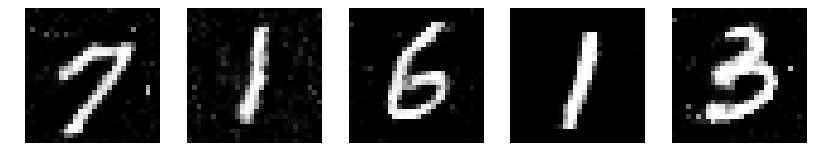

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
# 拿出5個examples
examples = 5
# 準備五個靈感
noise = np.random.normal(0, 1, (examples, random_dim))
# 使用創作者開始創作
gen_imgs = generator.predict(noise)

# 這裡要注意一下, 必須讓-1-1回到0-1才能被正確印出來
gen_imgs = 0.5 * gen_imgs + 0.5
# reshape成為圖片
gen_imgs = gen_imgs.reshape(examples, 28, 28)
# 設定一下完整畫布大小
plt.figure(figsize = (14, 14))
for i in range(0, examples):
    # 將大圖分成1 * 5五小圖, 編號分別為
    # 1, 2, 3, 4, 5
    # 所以i必須+1來得到相對應的小圖
    plt.subplot(1, examples, i + 1)
    # 不打印座標軸
    plt.axis('off')
    # 秀出圖片
    plt.imshow(gen_imgs[i], cmap='gray')

## Google Drive儲存

如果你使用的是Colab，但由於Colab每次的機器都是一次性的，所以要記得儲存在自己的Google Drive才可以保存！可以mount後做出儲存，mount就像插入一個光碟片，我將我的google drive插入後命名為gdrive，那大家預設的使用路徑都在My Drive裡，所以請創好/keras/gan資料夾即可儲存！

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
generator.save('/gdrive/My Drive/keras/gan/gan_gen.h5')
discriminator.save('/gdrive/My Drive/keras/gan/gan_dis.h5')